<a href="https://colab.research.google.com/github/AndyLiu0/2024SparseAutoencoder/blob/main/SparseEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import os
import time
import numpy as np
import argparse
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')

In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
device = get_device()
# make the `images` directory
def make_dir():
    image_dir = '../outputs/images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
make_dir()
# for saving the reconstructed images
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, name)

In [ ]:
# constructing argument parsers


epochs = 50
reg_param = 0.01
add_sparsity = 'yes'
learning_rate = 1e-3
batch_size = 32
act_function = nn.GELU()

threshold = 0.05
print(f"Add sparsity regularization: {add_sparsity}")

Add sparsity regularization: yes


In [ ]:
# tensor_transform = transforms.ToTensor()

# dataset = datasets.MNIST(root = "./data",
#                          train = True,
#                          download = True,
#                          transform = tensor_transform)


# loader = torch.utils.data.DataLoader(dataset = dataset,
#                                      batch_size = 32,
#                                      shuffle = True)
# image transformations

transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)

testset = datasets.MNIST(
    root='../input/data',
    train=False,
    download=True,
    transform=transform
)

# trainloader
trainloader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)
#testloader
testloader = DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
# define the autoencoder model
class SparseAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            act_function,
            nn.Linear(256, 128),
            act_function,
            nn.Linear(128, 64),
            act_function,
            nn.Linear(64, 32)
        )

        # decoder
        self.decoder = nn.Sequential(

            nn.Linear(32, 64),
            act_function,
            nn.Linear(64, 128),
            act_function,
            nn.Linear(128, 256),
            act_function,
            nn.Linear(256, 784)
        )

    def forward(self, x):
        # encoding
        enc = torch.sigmoid(self.encoder(x))
        # encoded = enc * (enc > threshold)
        encoded = enc

        decoded = self.decoder(encoded)

        return encoded, decoded

model = SparseAutoencoder()

In [ ]:
# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
model_children = list(model.children())

target = 0.05

def kl_divergence(rho, rho_hat):
    rho_hat = torch.mean(rho_hat, 0)
    # rho = torch.tensor([rho] * len(rho_hat)).to(device)
    # print(rho/rho_hat)
    # print((1 - rho)/(1 - rho_hat))
    # print(torch.log(rho/rho_hat))
    # print(torch.log((1 - rho)/(1 - rho_hat)))
    x = rho * torch.log(rho/rho_hat) + (1 - rho) * torch.log((1 - rho)/(1 - rho_hat))
    for i, n in enumerate(x):
      if not torch.isfinite(n) or n > 100:
        x[i] = 1
    # print(x)
    # if not torch.isfinite(x):
    #   x = torch.tensor(100)

    # if not torch.isfinite(x):
    #   print("x")
    #   print(x)
    #   print("i")
    #   for i in rho_hat:
    #     if not torch.isfinite(rho * torch.log(rho/i) + (1 - rho) * torch.log((1 - rho)/(1 - i))):
    #       print(i)

    return torch.mean(x)

def l1_loss(values):
    return torch.mean(torch.abs(values))

def sparse_loss(rho, values):

    #loss = kl_divergence(0.05, values)
    return l1_loss(values)

In [ ]:
print((kl_divergence(0.05, 0.000000001 * torch.ones([32, 16]))))
print((kl_divergence(0.05, 1 * torch.ones([32, 16]))))
print(kl_divergence(0.05, torch.arange(0, 1.0, 0.05).view(2, 10)))
print(l1_loss(0.5 * torch.ones([32,16])))
print(torch.mean(torch.ones([32,32]), 0))

tensor([0.8376, 0.8376, 0.8376, 0.8376, 0.8376, 0.8376, 0.8376, 0.8376, 0.8376,
        0.8376, 0.8376, 0.8376, 0.8376, 0.8376, 0.8376, 0.8376])
tensor(0.8376)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)
tensor([0.1441, 0.2005, 0.2632, 0.3326, 0.4094, 0.4946, 0.5900, 0.6975, 0.8204,
        0.9631])
tensor(0.4915)
tensor(0.5000)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


In [ ]:
def fit(model, dataloader, epoch):
    print('Training')
    model.train()
    running_loss = 0.0
    running_sp_penalty = 0.0
    counter = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(trainset)/dataloader.batch_size)):
        counter += 1
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        encoded, decoded = model(img)
        mse_loss = criterion(decoded, img)
        if add_sparsity == 'yes':
            sp_penalty = sparse_loss(0.05, encoded)

            loss = mse_loss + reg_param * sp_penalty
            running_sp_penalty += sp_penalty

        else:
            loss = mse_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / counter

    print(f"Train Loss: {loss:.4f}\t L1 Loss: {(running_sp_penalty / counter)}")

    # if epoch % 10 == 0:
    #     save_decoded_image(outputs.cpu().data, f"../outputs/images/train{epoch}.png")
    return epoch_loss

In [ ]:
def validate(model, dataloader, epoch):
    print('Validating')
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(testset)/dataloader.batch_size)):
            counter += 1
            img, _ = data
            img = img.to(device)
            img = img.view(img.size(0), -1)
            encoded, decoded = model(img)
            loss = criterion(decoded, img)
            running_loss += loss.item()

    epoch_loss = running_loss / counter
    print(f"Val Loss: {loss:.4f}")
    print(f"Non zeros: {torch.count_nonzero(encoded)}")
    print(f"Mean: {torch.mean(encoded):.4f}")
    # save the reconstructed images every 5 epochs
    # if epoch % 5 == 0:
    #     outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
    #     save_image(outputs, f"../outputs/images/reconstruction{epoch}.png")
    return epoch_loss

In [ ]:
accuracy_rec = []

train_loss = []
val_loss = []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, trainloader, epoch)
    val_epoch_loss = validate(model, testloader, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
end = time.time()
print(val_epoch_loss)
print(val_loss)
print(f"{int(end-start)} seconds")

Epoch 1 of 50
Training


100%|██████████| 1875/1875 [00:28<00:00, 65.16it/s]


Train Loss: 0.0353	 L1 Loss: 0.06295374780893326
Validating


313it [00:01, 163.34it/s]                         


Val Loss: 0.0334
Non zeros: 512
Mean: 0.0524
Epoch 2 of 50
Training


100%|██████████| 1875/1875 [00:28<00:00, 66.49it/s]


Train Loss: 0.0287	 L1 Loss: 0.05614246800541878
Validating


313it [00:01, 163.71it/s]                         


Val Loss: 0.0285
Non zeros: 512
Mean: 0.0509
Epoch 3 of 50
Training


100%|██████████| 1875/1875 [00:27<00:00, 67.15it/s]


Train Loss: 0.0304	 L1 Loss: 0.05225148797035217
Validating


313it [00:02, 122.01it/s]                         


Val Loss: 0.0252
Non zeros: 512
Mean: 0.0439
Epoch 4 of 50
Training


100%|██████████| 1875/1875 [00:27<00:00, 68.07it/s]


Train Loss: 0.0300	 L1 Loss: 0.04827960580587387
Validating


313it [00:01, 167.22it/s]                         


Val Loss: 0.0234
Non zeros: 512
Mean: 0.0424
Epoch 5 of 50
Training


100%|██████████| 1875/1875 [00:27<00:00, 67.54it/s]


Train Loss: 0.0268	 L1 Loss: 0.04687773063778877
Validating


313it [00:01, 168.97it/s]                         


Val Loss: 0.0221
Non zeros: 512
Mean: 0.0404
Epoch 6 of 50
Training


100%|██████████| 1875/1875 [00:27<00:00, 67.58it/s]


Train Loss: 0.0245	 L1 Loss: 0.04422204568982124
Validating


313it [00:02, 120.54it/s]                         


Val Loss: 0.0217
Non zeros: 512
Mean: 0.0385
Epoch 7 of 50
Training


100%|██████████| 1875/1875 [00:28<00:00, 66.39it/s]


Train Loss: 0.0217	 L1 Loss: 0.04195356369018555
Validating


313it [00:01, 166.00it/s]                         


Val Loss: 0.0209
Non zeros: 512
Mean: 0.0371
Epoch 8 of 50
Training


100%|██████████| 1875/1875 [00:27<00:00, 68.03it/s]


Train Loss: 0.0230	 L1 Loss: 0.04173955321311951
Validating


313it [00:01, 170.22it/s]                         


Val Loss: 0.0205
Non zeros: 512
Mean: 0.0377
Epoch 9 of 50
Training


100%|██████████| 1875/1875 [00:27<00:00, 67.48it/s]


Train Loss: 0.0210	 L1 Loss: 0.041317228227853775
Validating


313it [00:02, 134.26it/s]                         


Val Loss: 0.0191
Non zeros: 512
Mean: 0.0361
Epoch 10 of 50
Training


100%|██████████| 1875/1875 [00:29<00:00, 63.82it/s]


Train Loss: 0.0219	 L1 Loss: 0.04083949327468872
Validating


313it [00:01, 170.03it/s]                         


Val Loss: 0.0186
Non zeros: 512
Mean: 0.0357
Epoch 11 of 50
Training


100%|██████████| 1875/1875 [00:27<00:00, 68.29it/s]


Train Loss: 0.0197	 L1 Loss: 0.03984291851520538
Validating


313it [00:01, 168.25it/s]                         


Val Loss: 0.0180
Non zeros: 512
Mean: 0.0349
Epoch 12 of 50
Training


100%|██████████| 1875/1875 [00:27<00:00, 68.19it/s]


Train Loss: 0.0196	 L1 Loss: 0.038354139775037766
Validating


313it [00:01, 168.25it/s]                         


Val Loss: 0.0174
Non zeros: 512
Mean: 0.0338
Epoch 13 of 50
Training


100%|██████████| 1875/1875 [00:28<00:00, 66.53it/s]


Train Loss: 0.0209	 L1 Loss: 0.03702870383858681
Validating


313it [00:02, 130.42it/s]                         


Val Loss: 0.0165
Non zeros: 512
Mean: 0.0337
Epoch 14 of 50
Training


100%|██████████| 1875/1875 [00:27<00:00, 67.34it/s]


Train Loss: 0.0202	 L1 Loss: 0.035848990082740784
Validating


313it [00:01, 168.96it/s]                         


Val Loss: 0.0161
Non zeros: 512
Mean: 0.0325
Epoch 15 of 50
Training


100%|██████████| 1875/1875 [00:27<00:00, 67.77it/s]


Train Loss: 0.0177	 L1 Loss: 0.034891728311777115
Validating


313it [00:01, 164.03it/s]                         


Val Loss: 0.0163
Non zeros: 512
Mean: 0.0312
Epoch 16 of 50
Training


 35%|███▍      | 650/1875 [00:09<00:16, 73.03it/s]

In [ ]:
torch.save(model, "/Models/leaky32-3.pt")

torch.return_types.sort(
values=tensor([[6.3488e-03, 6.7833e-03, 9.1680e-03, 1.0402e-02, 1.5170e-02, 3.1909e-02,
         1.1135e-01, 3.2185e-01, 5.9169e-01, 8.9025e-01, 8.9746e-01, 8.9971e-01,
         9.7109e-01, 9.7807e-01, 9.8827e-01, 9.8942e-01],
        [3.8731e-04, 1.2675e-03, 2.5754e-03, 3.1950e-03, 8.8424e-03, 1.4621e-02,
         1.5525e-02, 2.0502e-02, 2.4104e-02, 7.9524e-02, 2.9407e-01, 6.5058e-01,
         8.9553e-01, 9.6336e-01, 9.8569e-01, 9.9085e-01],
        [1.7477e-05, 8.4688e-04, 1.1388e-03, 1.7108e-03, 1.9877e-03, 8.6742e-03,
         5.0616e-02, 5.2125e-02, 6.8365e-02, 1.1505e-01, 1.8935e-01, 6.0261e-01,
         8.5584e-01, 9.0525e-01, 9.9982e-01, 9.9996e-01],
        [2.3634e-04, 8.4388e-04, 1.4402e-03, 5.5437e-03, 6.6045e-03, 7.2358e-02,
         8.4855e-02, 9.6398e-02, 4.8880e-01, 5.6964e-01, 6.4049e-01, 9.0703e-01,
         9.2805e-01, 9.3703e-01, 9.4869e-01, 9.5086e-01],
        [2.0532e-02, 3.3018e-02, 6.3890e-02, 6.4063e-02, 8.2480e-02, 1.7794e-01,
       

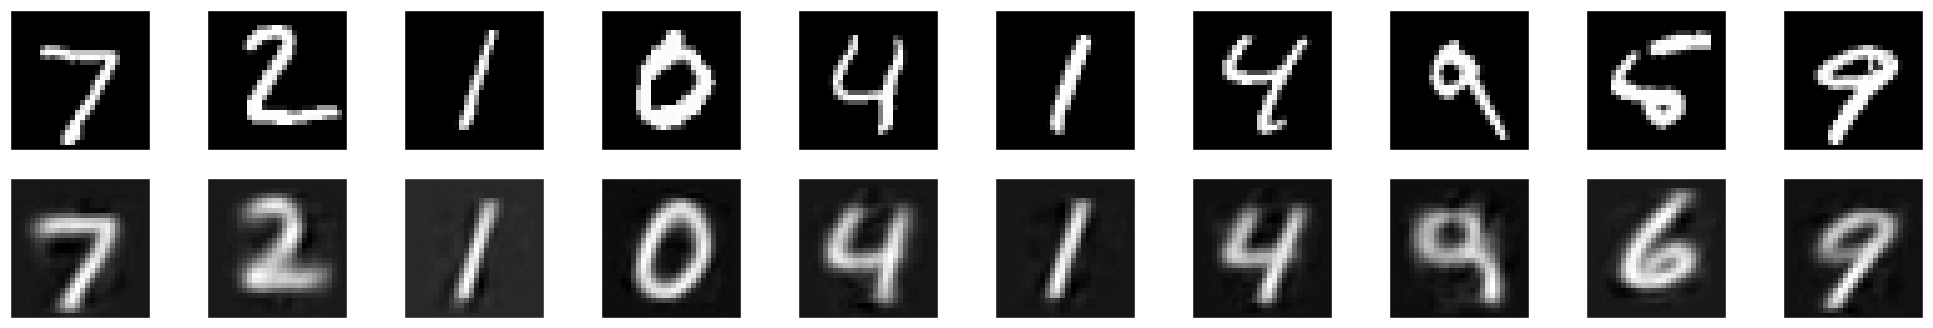

In [ ]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = next(dataiter)

images_flatten = images.view(images.size(0), -1)
# get sample outputs
encoded, decoded = model(images_flatten)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
decoded = decoded.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
decoded = decoded.detach().numpy()
print(torch.sort(encoded))
print(encoded.size())
print(torch.count_nonzero(encoded))
# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, decoded], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
